# Carga y unificación de dataset

In [1]:
import pandas as pd
import glob
import os

# Define the path to the datasets directory
dataset_path = 'datasets'

# Get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(dataset_path, '*.csv'))

# Load all CSV files into a list of DataFrames
dfs = []
for filename in csv_files:
    df = pd.read_csv(filename)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    
    # Remove the filename column if it exists
    if 'filename' in full_df.columns:
        full_df = full_df.drop(columns=['filename'])
    
    # Export the unified dataframe to a CSV file
    full_df.to_csv('unified_dataset.csv', index=False)
    print("Unified dataset exported to 'unified_dataset.csv'.")
    
    print("Dataset loaded successfully.")
    print(f"Total rows: {len(full_df)}")
    display(full_df.head())
else:
    print("No CSV files found in the datasets directory.")

Unified dataset exported to 'unified_dataset.csv'.
Dataset loaded successfully.
Total rows: 6000


,person,audio,noise,snr,provider,text,status,transcription_time
0,p7,1,cafe,0dB,custom,Genera una cotización para el cliente con fáci...,success,1.65
1,p7,1,cafe,5dB,custom,Genera una cotización para el cliente con PUC ...,success,1.56
2,p7,1,cafe,10dB,custom,Genera una cotización para el cliente con Puff...,success,1.59
3,p7,1,clean,NaN,custom,Genera una cotización para el cliente con FooF...,success,1.66
4,p7,1,traffic,0dB,custom,"genera una cotización para el cliente fácil, c...",success,1.53


In [2]:
mean_time_by_provider = full_df.groupby('provider')['transcription_time'].mean()
print("Mean Transcription Time by Provider:")
print(mean_time_by_provider)

Mean Transcription Time by Provider:
provider
amazon    12.379000
azure      2.338153
custom     1.380573
google     1.011293
Name: transcription_time, dtype: float64


# Normalización

In [3]:
import sys
import os

# Add the tools directory to the system path
sys.path.append(os.path.abspath('tools'))

from normalize import normalize_text

# Apply normalization to the text column
if 'text' in full_df.columns:
    full_df['text_normalized'] = full_df['text'].apply(normalize_text)
    print("Text column normalized successfully.")
    display(full_df.head(3))
    # full_df.to_csv('normalized_dataset.csv', index=False)
else:
    print("Text column not found in the dataframe.")

Text column normalized successfully.


,person,audio,noise,snr,provider,text,status,transcription_time,text_normalized
0,p7,1,cafe,0dB,custom,Genera una cotización para el cliente con fáci...,success,1.65,genera una cotización para el cliente con fáci...
1,p7,1,cafe,5dB,custom,Genera una cotización para el cliente con PUC ...,success,1.56,genera una cotización para el cliente con puc ...
2,p7,1,cafe,10dB,custom,Genera una cotización para el cliente con Puff...,success,1.59,genera una cotización para el cliente con puff...


In [4]:
filtered_df = full_df.loc[(full_df['person'] == 'p4') & (full_df['noise'] == 'clean') & (full_df['provider'] == 'custom')]
display(filtered_df[['audio','text']].head(3))

,audio,text
5253,1,Genera una cotización para el cliente CompuFac...
5263,2,Prepara un presupuesto urgente con 10 teclados...
5273,3,Crea una oferta comercial para Carla Santana c...


## Cálculo de WER

In [5]:
from wer_utils import calculate_wer_from_dataframe
wer, df_wer = calculate_wer_from_dataframe(full_df, 'ground_truth.json')
print(f"Global WER: {wer}")
df_wer.to_csv('wer_dataset.csv', index=False)

Global WER: 0.06281531531531531


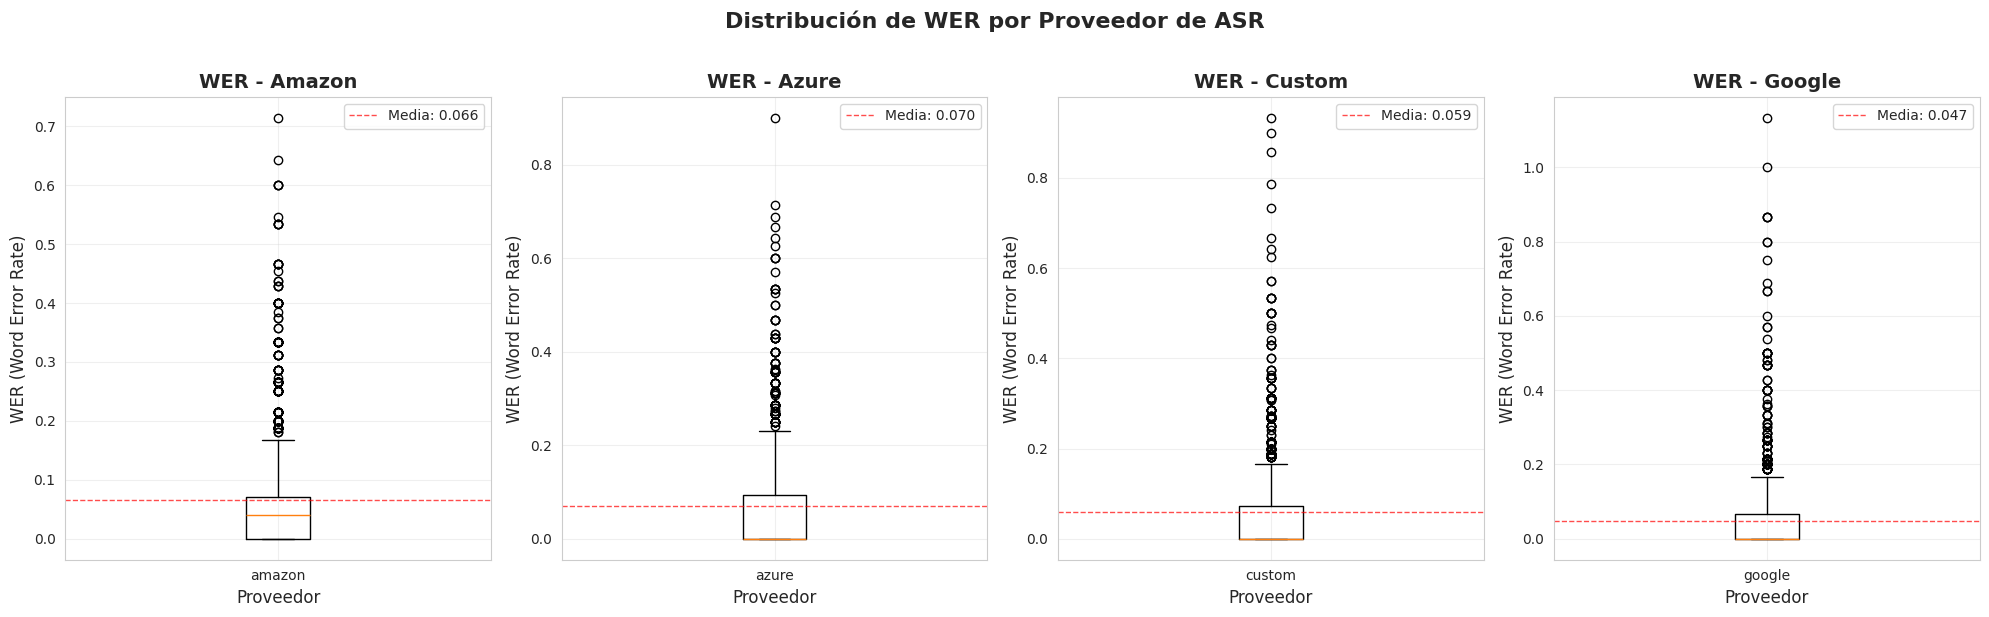


Estadísticas de WER por Proveedor:

AMAZON:
  Media:    0.0662
  Mediana:  0.0400
  Mínimo:   0.0000
  Máximo:   0.7143
  Desv. Est: 0.1004
  Muestras: 1500

AZURE:
  Media:    0.0703
  Mediana:  0.0000
  Mínimo:   0.0000
  Máximo:   0.9000
  Desv. Est: 0.1086
  Muestras: 1500

CUSTOM:
  Media:    0.0590
  Mediana:  0.0000
  Mínimo:   0.0000
  Máximo:   0.9333
  Desv. Est: 0.1085
  Muestras: 1500

GOOGLE:
  Media:    0.0475
  Mediana:  0.0000
  Mínimo:   0.0000
  Máximo:   1.1333
  Desv. Est: 0.1115
  Muestras: 1500


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de seaborn para gráficos más atractivos
sns.set_style("whitegrid")

# Obtener la lista de proveedores únicos
providers = df_wer['provider'].unique()

# Crear una figura con subplots para cada proveedor
fig, axes = plt.subplots(1, len(providers), figsize=(5*len(providers), 6))

# Crear un boxplot para cada proveedor
for idx, provider in enumerate(sorted(providers)):
    # Filtrar datos por proveedor
    provider_data = df_wer[df_wer['provider'] == provider]['wer']
    
    # Crear el boxplot
    axes[idx].boxplot(provider_data, tick_labels=[provider])
    axes[idx].set_title(f'WER - {provider.capitalize()}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('WER (Word Error Rate)', fontsize=12)
    axes[idx].set_xlabel('Proveedor', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    
    # Agregar estadísticas básicas
    mean_wer = provider_data.mean()
    median_wer = provider_data.median()
    axes[idx].axhline(y=mean_wer, color='r', linestyle='--', linewidth=1, alpha=0.7, label=f'Media: {mean_wer:.3f}')
    axes[idx].legend()

plt.suptitle('Distribución de WER por Proveedor de ASR', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Mostrar estadísticas descriptivas por proveedor
print("\nEstadísticas de WER por Proveedor:")
for provider in sorted(providers):
    provider_data = df_wer[df_wer['provider'] == provider]['wer']
    print(f"\n{provider.upper()}:")
    print(f"  Media:    {provider_data.mean():.4f}")
    print(f"  Mediana:  {provider_data.median():.4f}")
    print(f"  Mínimo:   {provider_data.min():.4f}")
    print(f"  Máximo:   {provider_data.max():.4f}")
    print(f"  Desv. Est: {provider_data.std():.4f}")
    print(f"  Muestras: {len(provider_data)}")

In [7]:
# Agrupar por proveedor y calcular totales para obtener el WER Global correcto
summary_df = df_wer.groupby('provider').agg(
    total_errors=('errors', 'sum'),
    total_words=('reference_words', 'sum')
).reset_index()

# Calcular WER Global: Suma de Errores / Suma de Palabras
summary_df['wer_global'] = summary_df['total_errors'] / summary_df['total_words']

# Renombrar columnas para la presentación
summary_table = summary_df.rename(columns={
    'provider': 'Motor',
    'wer_global': 'WER Global',
    'total_words': 'Total Palabras',
    'total_errors': 'Total Errores'
})

# Ordenar por WER ascendente (menor es mejor)
summary_table = summary_table.sort_values('WER Global')

# Mostrar la tabla con formato
print("Tabla Comparativa: Rendimiento Global por Motor ASR")
display(summary_table[['Motor', 'WER Global', 'Total Palabras', 'Total Errores']].style.format({
    'WER Global': '{:.2%}',
    'Total Palabras': '{:,.0f}',
    'Total Errores': '{:,.0f}'
}).hide(axis='index').set_properties(**{
    'text-align': 'center',
    'padding': '8px'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
]))

Tabla Comparativa: Rendimiento Global por Motor ASR


Motor,WER Global,Total Palabras,Total Errores
google,4.86%,"22,200","1,078"
custom,6.10%,"22,200","1,354"
amazon,6.86%,"22,200","1,523"
azure,7.31%,"22,200","1,623"


In [8]:
import matplotlib.pyplot as plt
import pandas as pd


# Definir el orden correcto de los niveles de SNR
snr_order = ['clean','10dB', '5dB', '0dB']

# Preparar los datos: calcular WER promedio por provider y SNR
# Normalizar los valores de SNR para asegurar consistencia
df_wer['snr_normalized'] = df_wer['snr'].astype(str).str.lower().str.replace('db', 'dB')

# Reemplazar 'nan' por 'clean' si es necesario
df_wer.loc[df_wer['snr_normalized'] == 'nan', 'snr_normalized'] = 'clean'

# Agrupar por provider y snr_normalized para calcular el WER correctamente
grouped_wer = df_wer.groupby(['provider', 'snr_normalized']).agg(
    total_errors=('errors', 'sum'),
    total_reference_words=('reference_words', 'sum')
).reset_index()

# Calcular el WER para cada grupo
grouped_wer['wer'] = grouped_wer['total_errors'] / grouped_wer['total_reference_words']

wer_by_provider_snr = grouped_wer[['provider', 'snr_normalized', 'wer']]


# Obtener lista de proveedores únicos
providers = sorted(df_wer['provider'].unique())
print("Providers found:", providers)
display(wer_by_provider_snr)


Providers found: ['amazon', 'azure', 'custom', 'google']


,provider,snr_normalized,wer
0,amazon,0dB,0.114414
1,amazon,10dB,0.043844
2,amazon,5dB,0.055856
3,amazon,clean,0.043694
4,azure,0dB,0.140240
5,azure,10dB,0.037988
6,azure,5dB,0.057958
7,azure,clean,0.022523
8,custom,0dB,0.124474
9,custom,10dB,0.029129


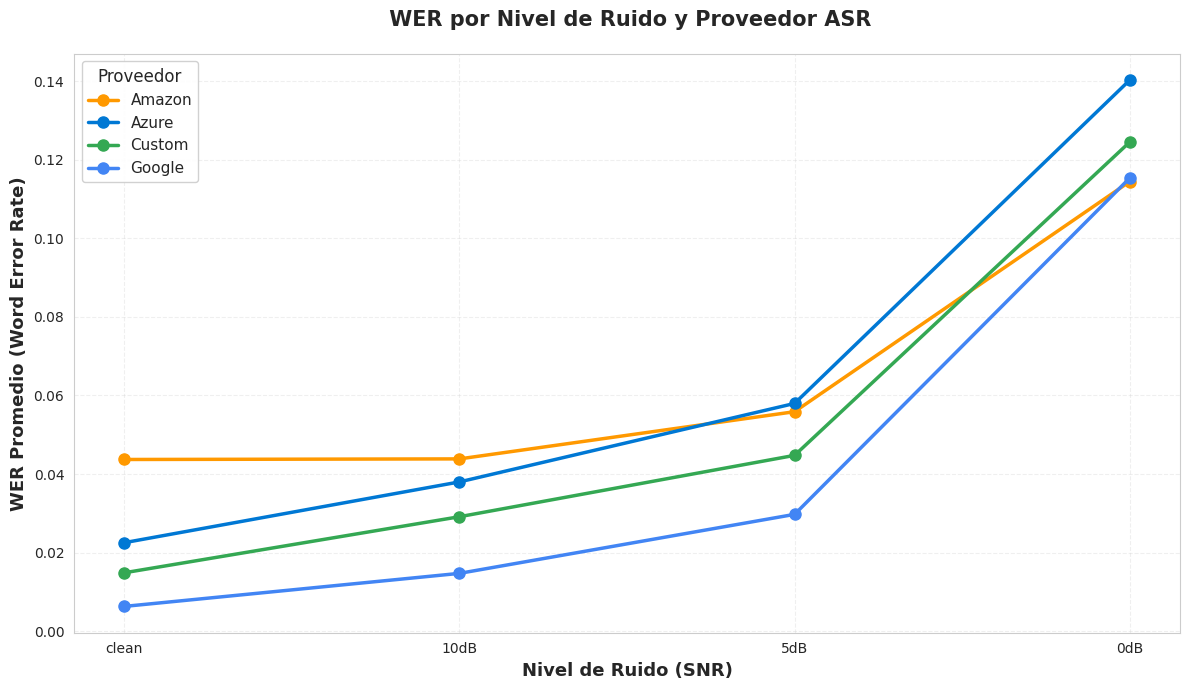


Tabla Comparativa de WER por Escenario y Degradación:


Motor,clean,10dB,5dB,0dB,Degradación (Delta)
amazon,4.37%,4.38%,5.59%,11.44%,+161.86%
azure,2.25%,3.80%,5.80%,14.02%,+522.67%
custom,1.49%,2.91%,4.47%,12.45%,+737.37%
google,0.63%,1.47%,2.97%,11.53%,+1728.57%


In [9]:
# Configurar el tamaño de la figura explícitamente para esta celda
plt.figure(figsize=(12, 7))

# Definir colores para cada proveedor
colors = {
    'google': '#4285F4',   # Azul Google
    'azure': '#0078D4',    # Azul Azure
    'amazon': '#FF9900',   # Naranja Amazon
    'custom': '#34A853'    # Verde
}

# Crear el gráfico de líneas
for provider in providers:
    # Filtrar datos para este proveedor
    provider_data = wer_by_provider_snr[wer_by_provider_snr['provider'] == provider]
    
    # Crear un DataFrame con todos los niveles de SNR para asegurar continuidad
    provider_full = pd.DataFrame({'snr_normalized': snr_order})
    provider_full = provider_full.merge(provider_data, on='snr_normalized', how='left')
    
    # Graficar la línea
    plt.plot(provider_full['snr_normalized'], 
             provider_full['wer'], 
             marker='o', 
             linewidth=2.5, 
             markersize=8,
             label=provider.capitalize(),
             color=colors.get(provider, None),
             linestyle='-')

# Configurar el gráfico
plt.xlabel('Nivel de Ruido (SNR)', fontsize=13, fontweight='bold')
plt.ylabel('WER Promedio (Word Error Rate)', fontsize=13, fontweight='bold')
plt.title(' WER por Nivel de Ruido y Proveedor ASR', 
          fontsize=15, fontweight='bold', pad=20)

# Configurar leyenda
plt.legend(title='Proveedor', fontsize=11, title_fontsize=12, 
           loc='best', framealpha=0.9)

# Configurar grid
plt.grid(True, alpha=0.3, linestyle='--')

# Ajustar layout
plt.tight_layout()
plt.show()

# --- Generar Tabla Comparativa Solicitada ---

# Pivotar la tabla: Filas=Provider, Columnas=SNR
detailed_table = wer_by_provider_snr.pivot(index='provider', 
                                           columns='snr_normalized', 
                                           values='wer')

# Asegurar el orden de las columnas de SNR
columns_order = [c for c in snr_order if c in detailed_table.columns]
detailed_table = detailed_table[columns_order]

# Calcular Degradación (Delta)
# Se calcula como el incremento porcentual del WER desde 'clean' hasta '0dB'
if 'clean' in detailed_table.columns and '0dB' in detailed_table.columns:
    detailed_table['Degradación (Delta)'] = (detailed_table['0dB'] - detailed_table['clean']) / detailed_table['clean']

# Resetear índice y renombrar columna de proveedor
detailed_table = detailed_table.reset_index().rename(columns={'provider': 'Motor'})

# Mostrar tabla formateada
print("\nTabla Comparativa de WER por Escenario y Degradación:")
display(detailed_table.style.format({
    'clean': '{:.2%}',
    '10dB': '{:.2%}',
    '5dB': '{:.2%}',
    '0dB': '{:.2%}',
    'Degradación (Delta)': '{:+.2%}'
}).hide(axis='index').set_properties(**{
    'text-align': 'center',
    'padding': '8px'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
]))

Recalculando WER con desglose de errores...


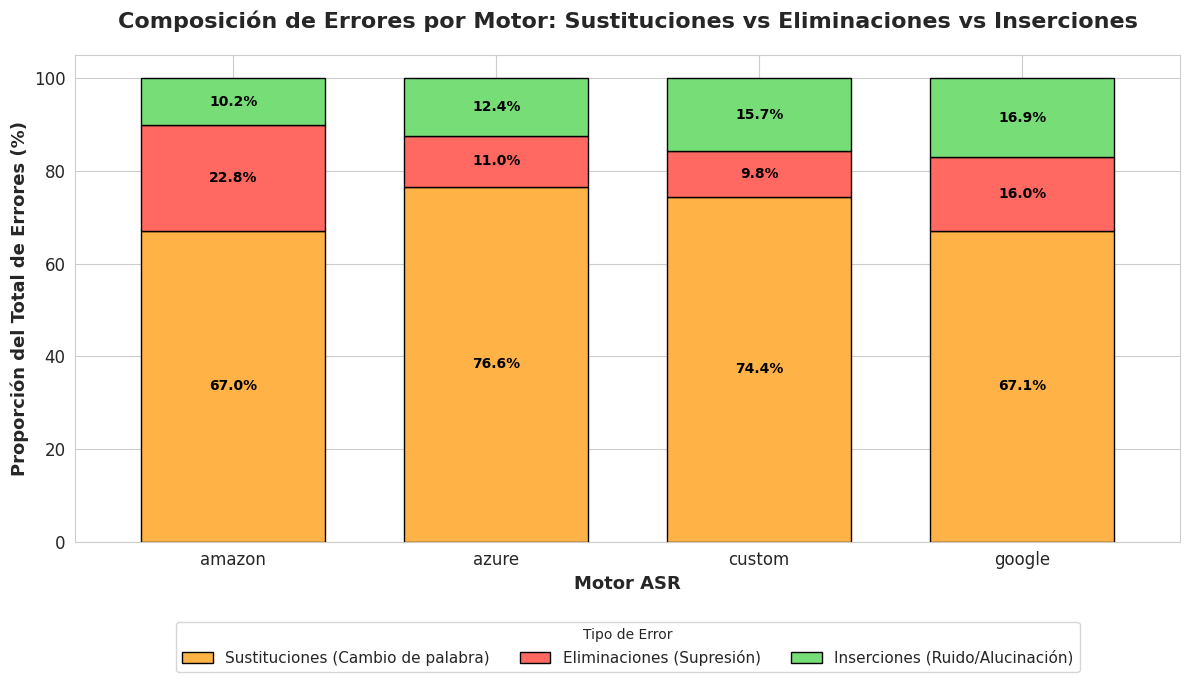


Desglose de Errores (Cantidad y Porcentaje):


,substitutions,deletions,insertions,substitutions (%),deletions (%),insertions (%)
provider,,,,,,
amazon,1021.000000,347.000000,155.000000,67.0,22.8,10.2
azure,1243.000000,179.000000,201.000000,76.6,11.0,12.4
custom,1008.000000,133.000000,213.000000,74.4,9.8,15.7
google,723.000000,173.000000,182.000000,67.1,16.0,16.9


In [10]:
import importlib
import wer_utils
import matplotlib.pyplot as plt
import pandas as pd

# 1. Recargar módulo y recalcular WER para obtener desglose S/D/I
# Es necesario recargar para asegurar que se use la versión actualizada de wer_utils que devuelve S/D/I
importlib.reload(wer_utils)
from wer_utils import calculate_wer_from_dataframe

print("Recalculando WER con desglose de errores...")
wer_global, df_detailed = calculate_wer_from_dataframe(full_df, 'ground_truth.json')

# 2. Agrupar por proveedor y sumar componentes de error
error_components = ['substitutions', 'deletions', 'insertions']
error_breakdown = df_detailed.groupby('provider')[error_components].sum()

# 3. Calcular porcentajes (Normalizar al 100% de los errores totales de cada proveedor)
error_breakdown['total_errors'] = error_breakdown.sum(axis=1)
error_breakdown_pct = error_breakdown[error_components].div(error_breakdown['total_errors'], axis=0) * 100

# 4. Graficar Barras Apiladas al 100%
ax = error_breakdown_pct.plot(kind='bar', stacked=True, figsize=(12, 7), 
                              color=['#FFB347', '#FF6961', '#77DD77'], # Naranja (S), Rojo (D), Verde (I)
                              edgecolor='black', width=0.7)

# Configuración del gráfico
plt.title('Composición de Errores por Motor: Sustituciones vs Eliminaciones vs Inserciones', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Motor ASR', fontsize=13, fontweight='bold')
plt.ylabel('Proporción del Total de Errores (%)', fontsize=13, fontweight='bold')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Configurar leyenda
plt.legend(title='Tipo de Error', labels=['Sustituciones (Cambio de palabra)', 'Eliminaciones (Supresión)', 'Inserciones (Ruido/Alucinación)'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=11)

# Añadir etiquetas de porcentaje en el centro de las barras
for c in ax.containers:
    # Filtrar etiquetas para barras muy pequeñas
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 3 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='black', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Mostrar tabla de datos absolutos y porcentuales
print("\nDesglose de Errores (Cantidad y Porcentaje):")
display(pd.concat([error_breakdown[error_components], error_breakdown_pct.add_suffix(' (%)')], axis=1).style.format("{:.1f}", subset=error_breakdown_pct.columns.map(lambda x: x + ' (%)')))

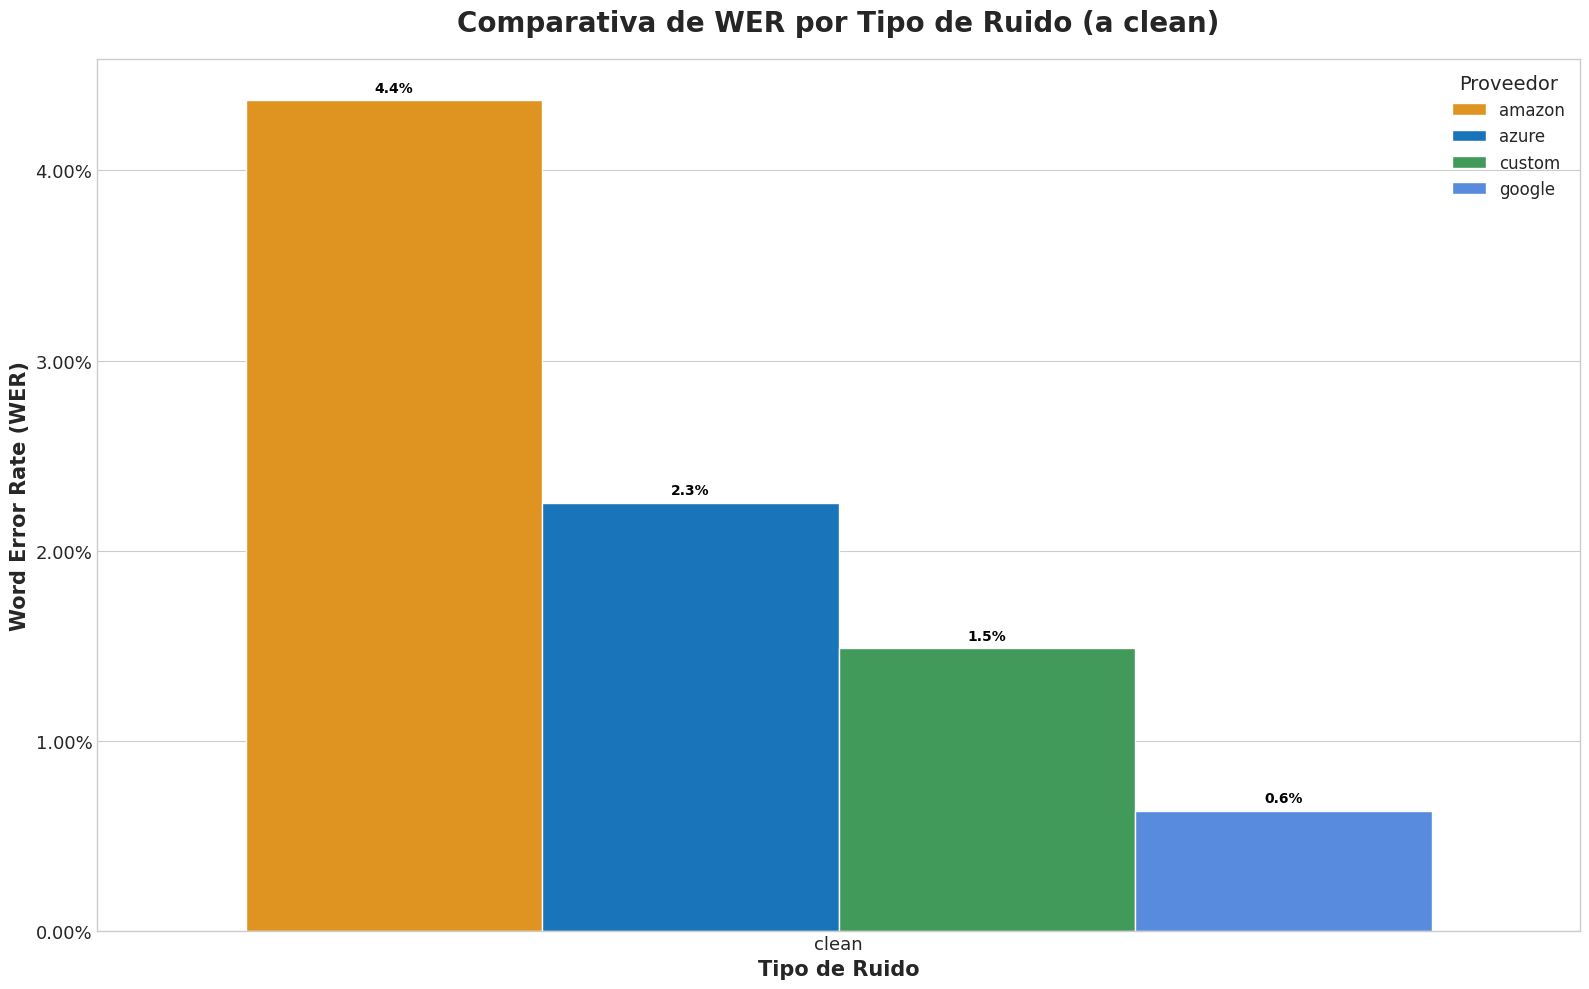

Datos de WER a clean por Tipo de Ruido y Proveedor:


,noise,provider,wer
3,clean,google,0.006306
2,clean,custom,0.014865
1,clean,azure,0.022523
0,clean,amazon,0.043694


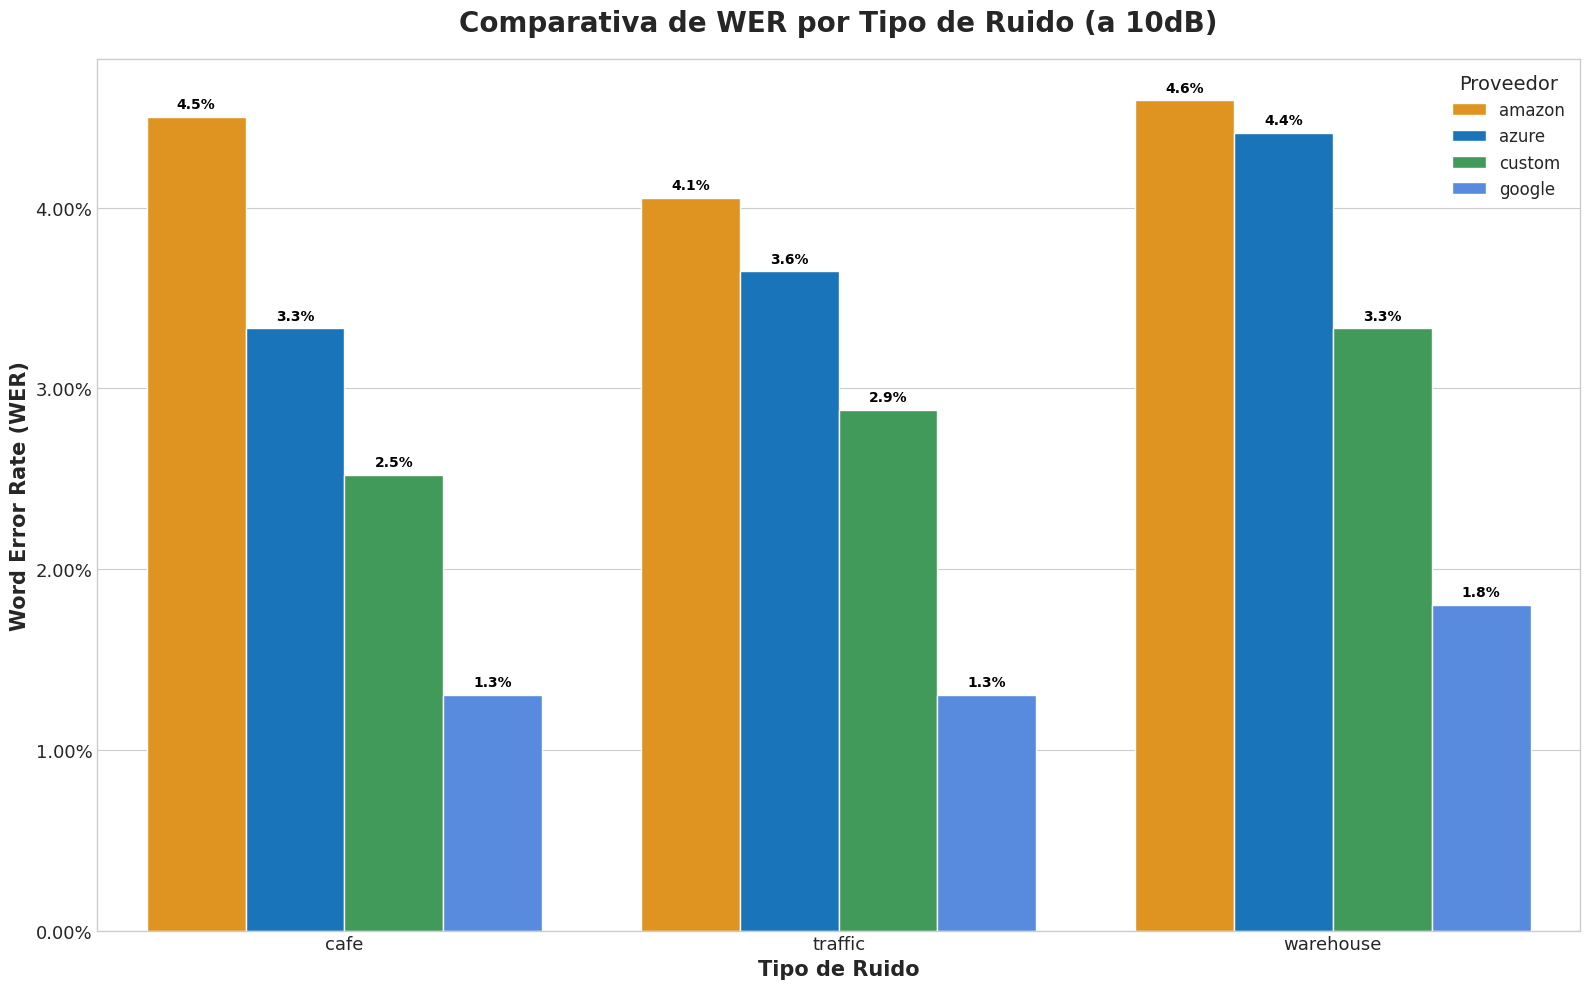

Datos de WER a 10dB por Tipo de Ruido y Proveedor:


,noise,provider,wer
3,cafe,google,0.013063
2,cafe,custom,0.025225
1,cafe,azure,0.033333
0,cafe,amazon,0.045045
7,traffic,google,0.013063
6,traffic,custom,0.028829
5,traffic,azure,0.036486
4,traffic,amazon,0.040541
11,warehouse,google,0.018018
10,warehouse,custom,0.033333


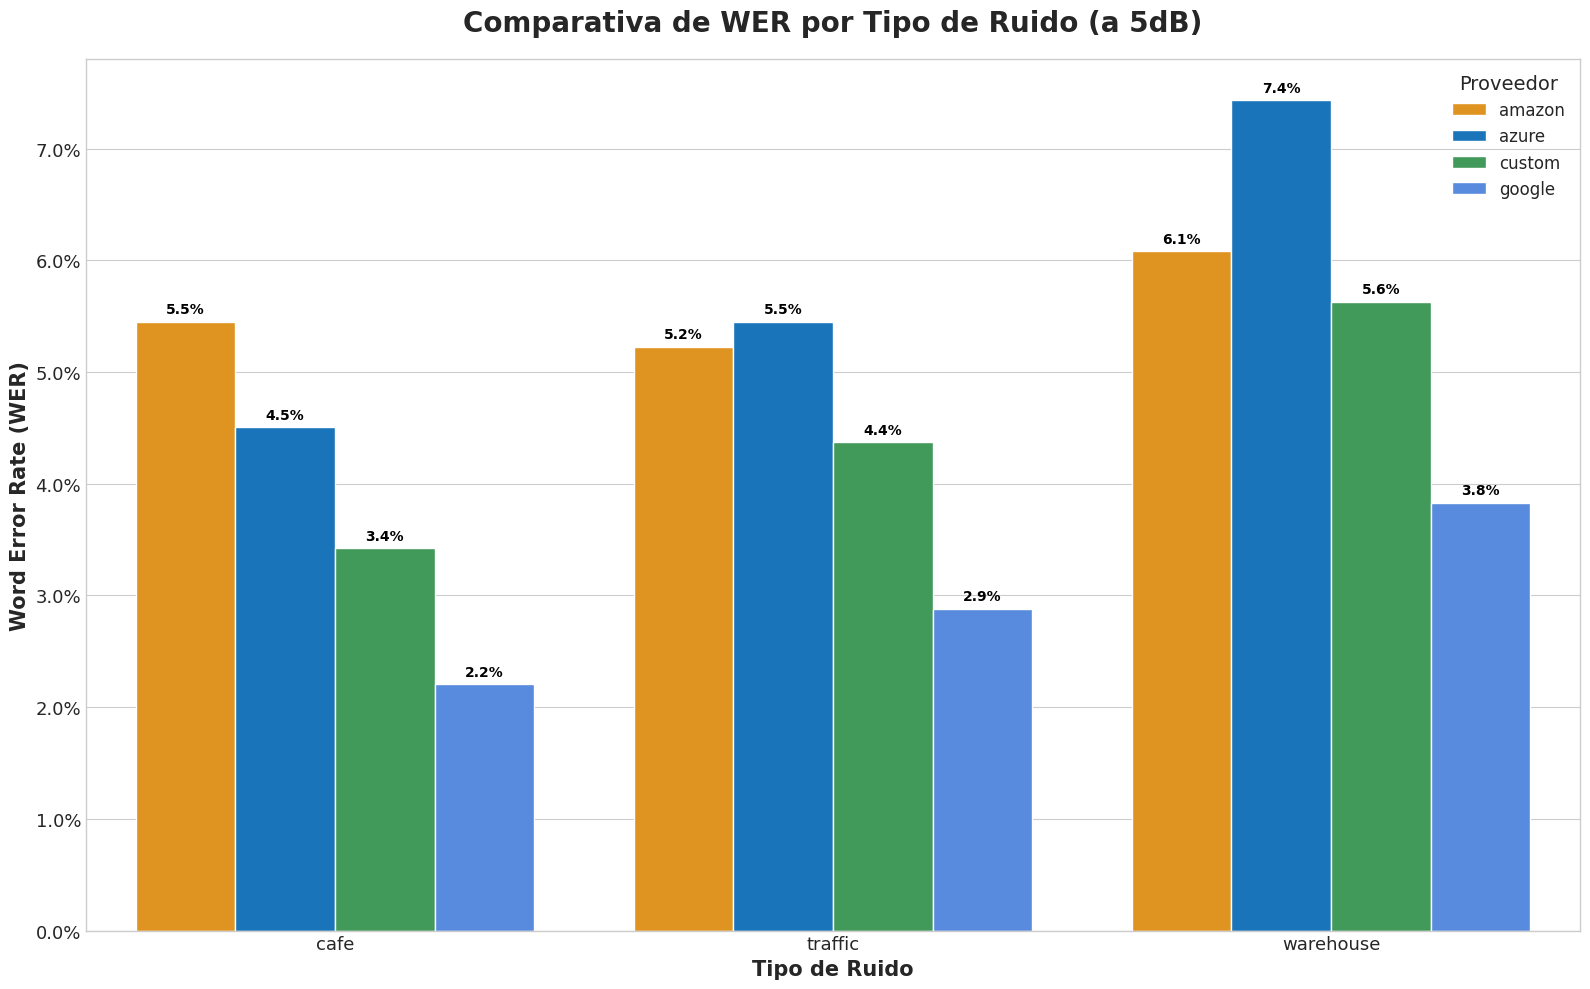

Datos de WER a 5dB por Tipo de Ruido y Proveedor:


,noise,provider,wer
3,cafe,google,0.022072
2,cafe,custom,0.034234
1,cafe,azure,0.045045
0,cafe,amazon,0.054505
7,traffic,google,0.028829
6,traffic,custom,0.043694
4,traffic,amazon,0.052252
5,traffic,azure,0.054505
11,warehouse,google,0.038288
10,warehouse,custom,0.056306


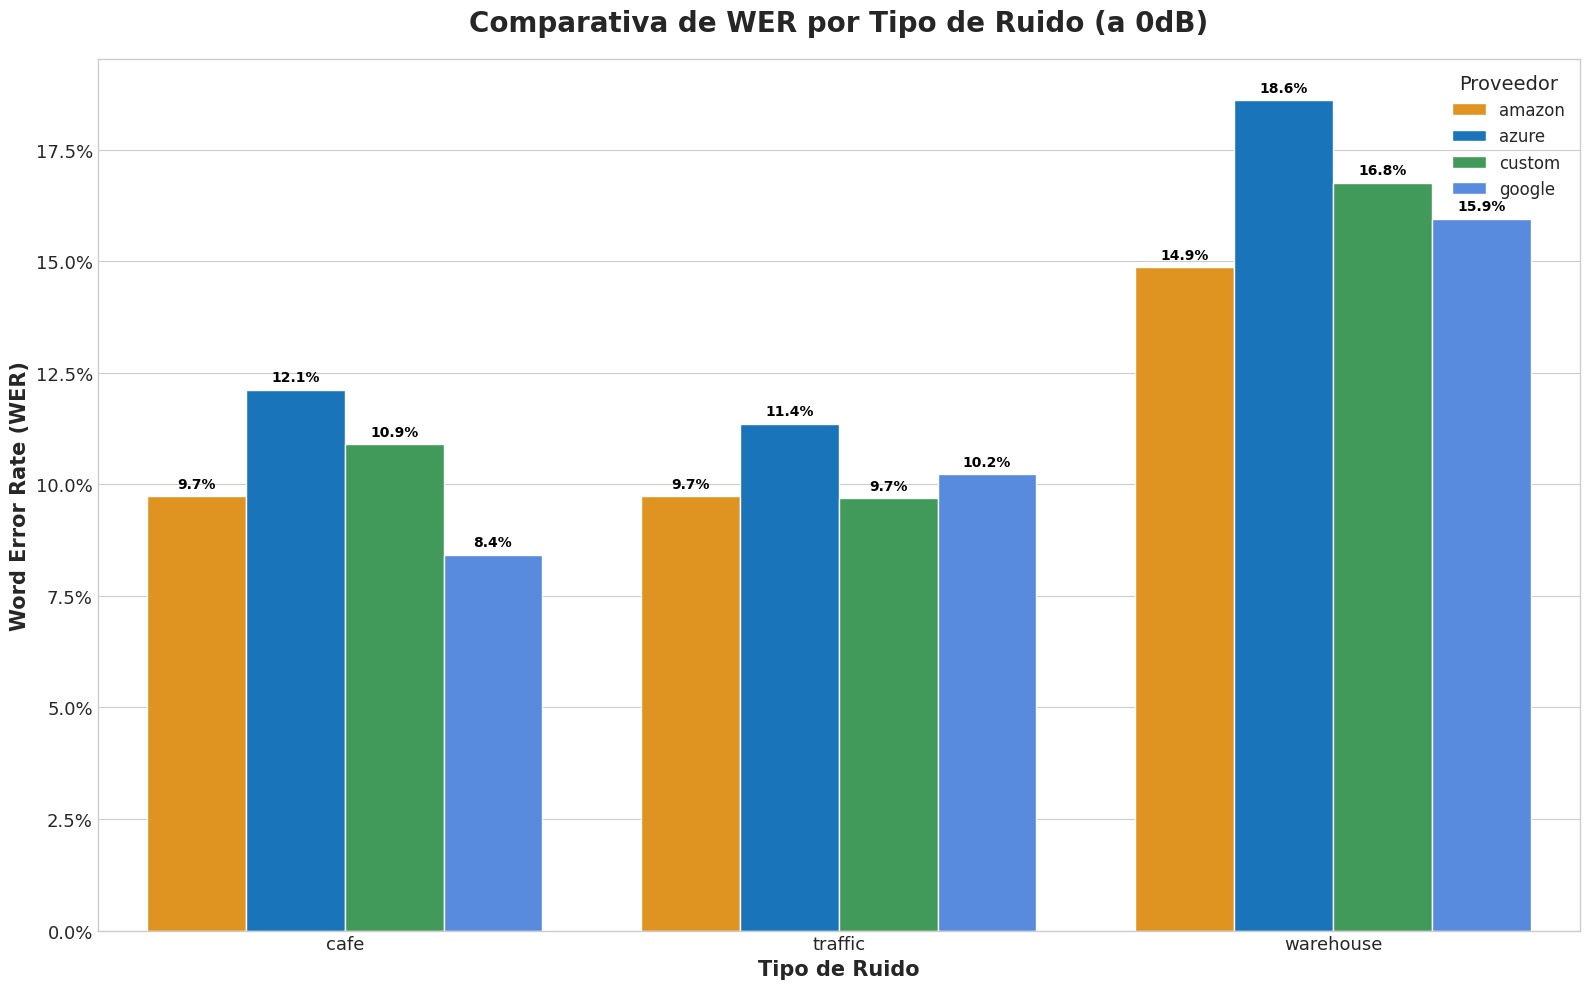

Datos de WER a 0dB por Tipo de Ruido y Proveedor:


,noise,provider,wer
3,cafe,google,0.084234
0,cafe,amazon,0.097297
2,cafe,custom,0.109009
1,cafe,azure,0.121171
6,traffic,custom,0.096847
4,traffic,amazon,0.097297
7,traffic,google,0.102252
5,traffic,azure,0.113514
8,warehouse,amazon,0.148649
11,warehouse,google,0.159459


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import PercentFormatter

def analyze_wer_by_snr(df, snr_level):
    """
    Genera un gráfico de barras y una tabla de WER para un nivel de SNR específico.
    """
    # 1. Filtrar los datos para el nivel de ruido específico
    df_filtered = df[df['snr_normalized'] == snr_level].copy()
    
    if df_filtered.empty:
        print(f"No hay datos para el nivel de ruido: {snr_level}")
        return

    # 2. Calcular el WER agregado por tipo de ruido y proveedor
    wer_by_noise = df_filtered.groupby(['noise', 'provider']).agg(
        total_errors=('errors', 'sum'),
        total_reference_words=('reference_words', 'sum')
    ).reset_index()

    # Calcular el WER correcto para cada grupo
    wer_by_noise['wer'] = (wer_by_noise['total_errors'] / wer_by_noise['total_reference_words'])

    # 3. Crear el gráfico de barras agrupadas
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 10))

    sns.barplot(data=wer_by_noise, x='noise', y='wer', hue='provider', ax=ax,
                palette={'google': '#4285F4', 'azure': '#0078D4', 'amazon': '#FF9900', 'custom': '#34A853'})

    # 4. Formatear y embellecer el gráfico
    ax.set_title(f'Comparativa de WER por Tipo de Ruido (a {snr_level})', fontsize=20, fontweight='bold', pad=20)
    ax.set_xlabel('Tipo de Ruido', fontsize=15, fontweight='bold')
    ax.set_ylabel('Word Error Rate (WER)', fontsize=15, fontweight='bold')

    # Formatear el eje Y como porcentaje
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    # Ajustar la leyenda
    ax.legend(title='Proveedor', title_fontsize='14', fontsize='12', loc='upper right')

    # Mejorar la legibilidad de las etiquetas del eje X
    plt.xticks(rotation=0, ha='center', fontsize=13)
    plt.yticks(fontsize=13)

    # Añadir valores en la parte superior de cada barra
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.1%}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points',
                        fontsize=10, 
                        fontweight='bold', 
                        color='black')

    plt.tight_layout()
    plt.show()

    # Mostrar la tabla de datos
    print(f"Datos de WER a {snr_level} por Tipo de Ruido y Proveedor:")
    display(wer_by_noise[['noise', 'provider', 'wer']].sort_values(by=['noise', 'wer']))

# Ejecutar para los 4 niveles de SNR
snr_levels = ['clean', '10dB', '5dB', '0dB']

for snr in snr_levels:
    analyze_wer_by_snr(df_wer, snr)

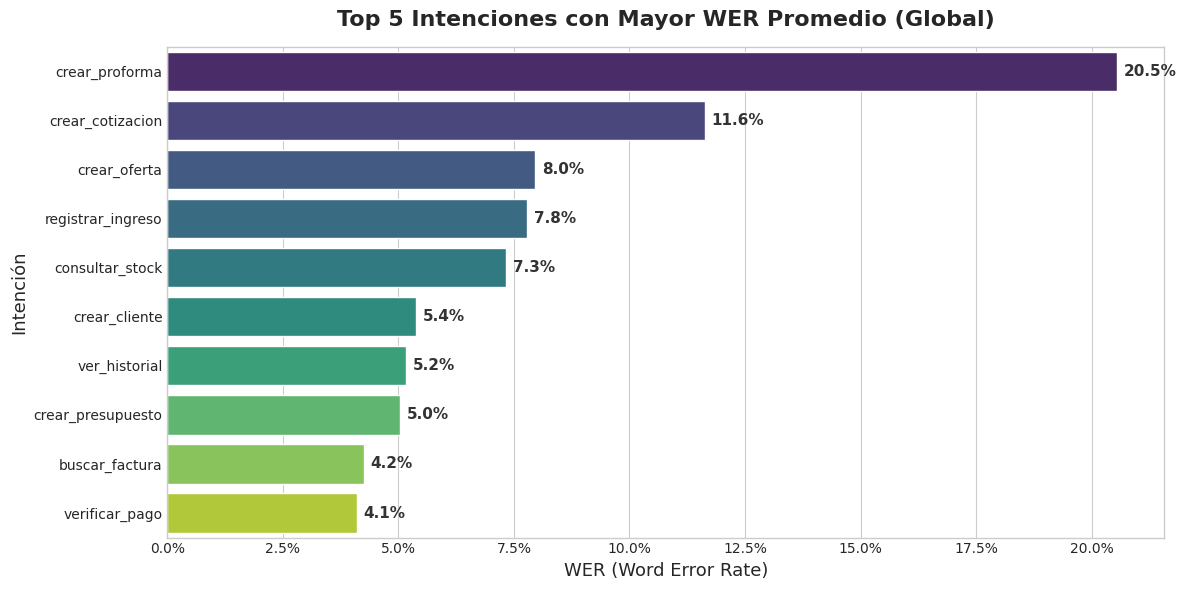

Intenciones con Mayor WER:


,intent,wer,total_errors,total_reference_words
7,crear_proforma,0.205500,1233.0,6000.0
4,crear_cotizacion,0.116250,744.0,6400.0
5,crear_oferta,0.079500,477.0,6000.0
10,registrar_ingreso,0.077857,436.0,5600.0
2,consultar_stock,0.073214,410.0,5600.0
3,crear_cliente,0.053800,538.0,10000.0
13,ver_historial,0.051607,289.0,5600.0
6,crear_presupuesto,0.050313,322.0,6400.0
0,buscar_factura,0.042500,238.0,5600.0
14,verificar_pago,0.040921,311.0,7600.0


In [12]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# 1. Cargar reglas de NLU para obtener las intenciones
with open('tools/nlu_rules.json', 'r', encoding='utf-8') as f:
    nlu_rules = json.load(f)

# Crear mapeo de audio_id -> intent
id_to_intent = {str(k): v['intent'] for k, v in nlu_rules.items()}

# 2. Asignar intención al dataframe de WER
# Usamos una copia para no afectar el dataframe original globalmente
df_intent_analysis = df_wer.copy()
df_intent_analysis['intent'] = df_intent_analysis['audio'].astype(str).map(id_to_intent)

# 3. Calcular WER Global por Intención
# Agrupar por intención y sumar errores y palabras de referencia
wer_by_intent = df_intent_analysis.groupby('intent').agg(
    total_errors=('errors', 'sum'),
    total_reference_words=('reference_words', 'sum')
).reset_index()

# Calcular WER: total_errors / total_reference_words
wer_by_intent['wer'] = wer_by_intent['total_errors'] / wer_by_intent['total_reference_words']

# 4. Filtrar Top 5 Intenciones con Mayor WER
top_5_intents = wer_by_intent.sort_values(by='wer', ascending=False).head(10)

# 5. Graficar
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Crear gráfico de barras horizontal
# Se asigna 'intent' a 'hue' y se desactiva la leyenda para evitar el warning de deprecación
ax = sns.barplot(data=top_5_intents, x='wer', y='intent', hue='intent', palette='viridis', legend=False)

# Configurar títulos y ejes
ax.set_title('Top 5 Intenciones con Mayor WER Promedio (Global)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('WER (Word Error Rate)', fontsize=13)
ax.set_ylabel('Intención', fontsize=13)

# Formatear eje X como porcentaje
ax.xaxis.set_major_formatter(PercentFormatter(1.0))

# Añadir etiquetas de valor al final de las barras
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'{width:.1%}', 
                    (width, p.get_y() + p.get_height() / 2.), 
                    ha='left', va='center', 
                    xytext=(5, 0), 
                    textcoords='offset points',
                    fontsize=11, fontweight='bold', color='#333333')

# Ajustar márgenes
plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("Intenciones con Mayor WER:")
display(top_5_intents[['intent', 'wer', 'total_errors', 'total_reference_words']])

In [13]:
import pandas as pd

# 1. Preparar datos (Recalculando para asegurar disponibilidad en esta celda)
# Agrupar por provider y snr_normalized
ranking_grouped = df_wer.groupby(['provider', 'snr_normalized']).agg(
    total_errors=('errors', 'sum'),
    total_reference_words=('reference_words', 'sum')
).reset_index()

# Calcular WER Global
ranking_grouped['wer'] = ranking_grouped['total_errors'] / ranking_grouped['total_reference_words']

# 2. Definir orden y etiquetas de escenarios
snr_order = ['clean', '10dB', '5dB', '0dB']
scenario_labels = {
    'clean': 'Silencio (Clean)',
    '10dB': 'Ruido Moderado (10dB)',
    '5dB': 'Ruido Alto (5dB)',
    '0dB': 'Ruido Extremo (0dB)'
}

# 3. Construir el ranking
ranking_rows = []

for snr in snr_order:
    # Filtrar y ordenar por WER ascendente (menor es mejor)
    subset = ranking_grouped[ranking_grouped['snr_normalized'] == snr].sort_values(by='wer')
    
    if not subset.empty:
        # Mejor motor (Top 1)
        best = subset.iloc[0]
        best_str = f"{best['provider'].capitalize()} (~{best['wer']:.1%})"
        
        # Motor alterno (Top 2)
        if len(subset) > 1:
            alt = subset.iloc[1]
            alt_str = f"{alt['provider'].capitalize()} (~{alt['wer']:.1%})"
        else:
            alt_str = "-"
            
        ranking_rows.append({
            'Escenario': scenario_labels.get(snr, snr),
            'Mejor Motor': best_str,
            'Motor Alterno': alt_str
        })

# 4. Crear DataFrame y mostrar
df_ranking = pd.DataFrame(ranking_rows)

print("Tabla de Ranking: Mejor Motor vs Alterno por Escenario")
# Estilizar la tabla para mejor visualización
display(df_ranking.style.hide(axis='index').set_properties(**{
    'text-align': 'left',
    'font-size': '12pt',
    'padding': '8px'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left'), ('font-size', '12pt'), ('font-weight', 'bold')]}
]))

Tabla de Ranking: Mejor Motor vs Alterno por Escenario


Escenario,Mejor Motor,Motor Alterno
Silencio (Clean),Google (~0.6%),Custom (~1.5%)
Ruido Moderado (10dB),Google (~1.5%),Custom (~2.9%)
Ruido Alto (5dB),Google (~3.0%),Custom (~4.5%)
Ruido Extremo (0dB),Amazon (~11.4%),Google (~11.5%)


## Métricas NLU

In [14]:
from tools.nlu_utils import NLUEvaluator

# Initialize the evaluator
nlu_evaluator = NLUEvaluator()

df_nlu = nlu_evaluator.evaluate_dataset(df_wer)

# Display results
print("NLU Evaluation Completed.")
display(df_nlu[['audio', 'provider', 'text_normalized', 'intent_success', 'slots_success', 'nlu_success']].head())

# Calculate metrics
nlu_metrics = df_nlu.groupby('provider')[['intent_success', 'slots_success', 'nlu_success']].mean()
print("\nNLU Metrics by Provider:")
display(nlu_metrics)


NLU Evaluation Completed.


,audio,provider,text_normalized,intent_success,slots_success,nlu_success
0,1,custom,genera una cotización para el cliente con fáci...,True,False,False
1,1,custom,genera una cotización para el cliente con puc ...,True,False,False
2,1,custom,genera una cotización para el cliente con puff...,True,False,False
3,1,custom,genera una cotización para el cliente con foof...,True,False,False
4,1,custom,genera una cotización para el cliente fácil co...,True,False,False



NLU Metrics by Provider:


,intent_success,slots_success,nlu_success
provider,,,
amazon,0.953333,0.803333,0.768000
azure,0.950667,0.852667,0.817333
custom,0.953333,0.858000,0.826667
google,0.960000,0.866667,0.845333


In [68]:
import pandas as pd

def generar_tabla_eficacia(df, columnas_agrupacion):
    """
    Calcula la tabla de eficacia semántica agrupando por las columnas especificadas.
    """
    # 1. Calcular métricas de eficacia semántica
    # Se asume que 'intent_success' es la detección de intención y 'slots_success' es el NLU Recall (Solo Slots)
    efficacy_df = df.groupby(columnas_agrupacion).agg(
        intent_acc=('intent_success', 'mean'),
        nlu_acc=('slots_success', 'mean')
    ).reset_index()

    # 2. Calcular diferencial (NLU Recall - Detección de Intención)
    efficacy_df['differential'] = efficacy_df['nlu_acc'] - efficacy_df['intent_acc']

    # 3. Renombrar columnas para la tabla final
    rename_map = {
        'provider': 'Proveedor',
        'snr_normalized': 'SNR',
        'intent_acc': '% Detección de Intención',
        'nlu_acc': '% Recuperación de Entidades',
        'differential': 'Diferencial'
    }
    efficacy_table = efficacy_df.rename(columns=rename_map)

    # 4. Ordenar por Proveedor (y SNR si existe)
    sort_cols = ['Proveedor']
    if 'SNR' in efficacy_table.columns:
        # Definir orden lógico para SNR
        snr_order = ['clean', '10dB', '5dB', '0dB']
        # Convertir a categórico para ordenar correctamente
        efficacy_table['SNR'] = pd.Categorical(efficacy_table['SNR'], categories=snr_order, ordered=True)
        sort_cols.append('SNR')
        
    efficacy_table = efficacy_table.sort_values(sort_cols)
    
    return efficacy_table

def mostrar_tabla_eficacia(df, titulo):
    """
    Muestra la tabla de eficacia con el formato estilizado.
    """
    print(titulo)
    display(df.style.format({
        '% Detección de Intención': '{:.2%}',
        '% Recuperación de Entidades': '{:.2%}',
        'Diferencial': '{:+.2%}'
    }).hide(axis='index').set_properties(**{
        'text-align': 'center',
        'padding': '8px'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
    ]).background_gradient(cmap='RdYlGn', subset=['% Detección de Intención', '% Recuperación de Entidades']))

# Generar y mostrar la tabla global (solo por proveedor)
tabla_global = generar_tabla_eficacia(df_nlu, ['provider'])
mostrar_tabla_eficacia(tabla_global, "Tabla de Eficacia de Extracción Semántica (Global)")

Tabla de Eficacia de Extracción Semántica (Global)


Proveedor,% Detección de Intención,% Recuperación de Entidades,Diferencial
amazon,95.33%,80.33%,-15.00%
azure,95.07%,85.27%,-9.80%
custom,95.33%,85.80%,-9.53%
google,96.00%,86.67%,-9.33%


In [70]:
# Generar y mostrar la tabla detallada por Proveedor y SNR
# Reutilizamos las funciones definidas en la celda anterior
tabla_snr = generar_tabla_eficacia(df_nlu, ['provider', 'snr_normalized'])
mostrar_tabla_eficacia(tabla_snr, "Tabla de Eficacia de Extracción Semántica por SNR")

Tabla de Eficacia de Extracción Semántica por SNR


Proveedor,SNR,% Detección de Intención,% Recuperación de Entidades,Diferencial
amazon,clean,94.67%,88.00%,-6.67%
amazon,10dB,96.22%,89.56%,-6.67%
amazon,5dB,96.89%,84.22%,-12.67%
amazon,0dB,93.11%,64.67%,-28.44%
azure,clean,99.33%,98.00%,-1.33%
azure,10dB,99.11%,94.22%,-4.89%
azure,5dB,97.11%,89.33%,-7.78%
azure,0dB,87.56%,68.00%,-19.56%
custom,clean,98.67%,98.00%,-0.67%
custom,10dB,97.33%,94.22%,-3.11%


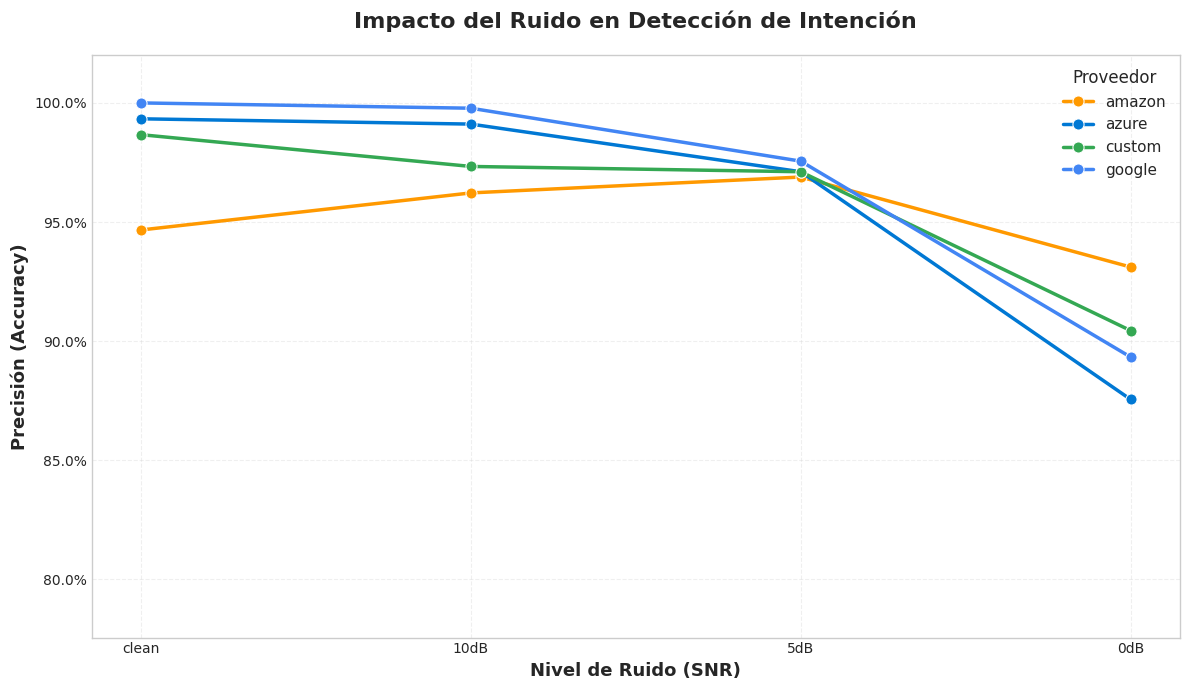

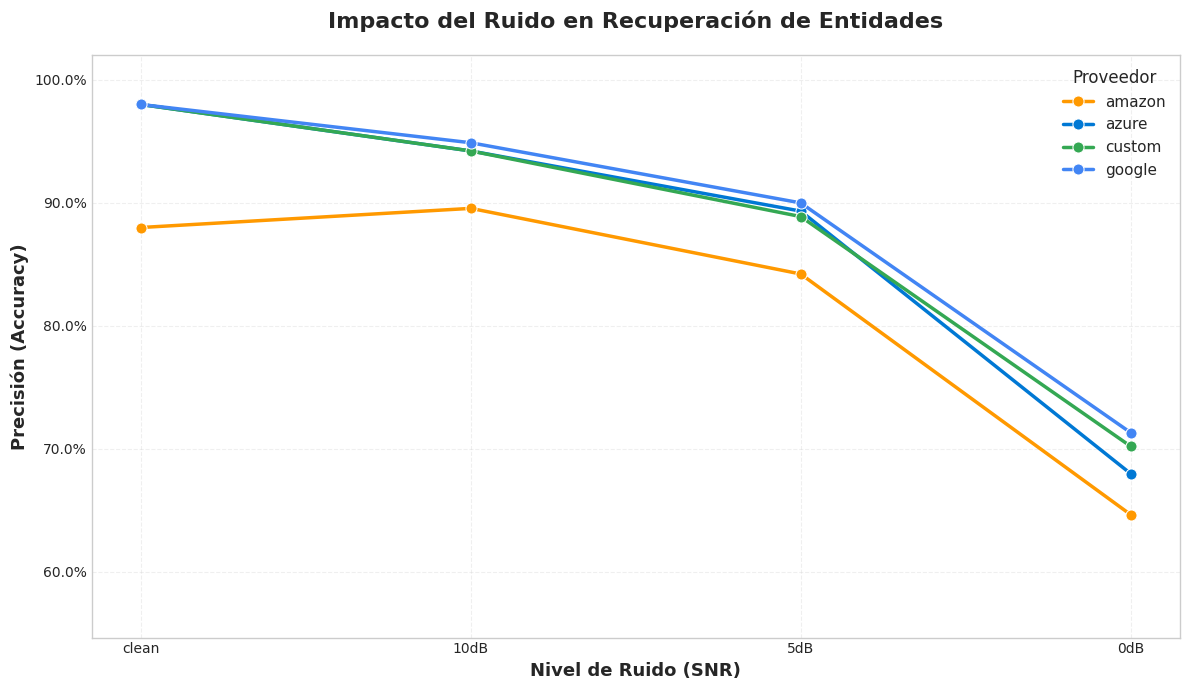

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import PercentFormatter

# 1. Preparar datos
# Agrupar por proveedor y SNR
nlu_evolution = df_nlu.groupby(['provider', 'snr_normalized']).agg(
    intent_acc=('intent_success', 'mean'),
    nlu_acc=('slots_success', 'mean')
).reset_index()

# Definir orden de SNR
snr_order = ['clean', '10dB', '5dB', '0dB']

# Crear columna categórica para ordenar correctamente el eje X
nlu_evolution['snr_cat'] = pd.Categorical(nlu_evolution['snr_normalized'], categories=snr_order, ordered=True)
nlu_evolution = nlu_evolution.sort_values('snr_cat')

# 2. Configurar gráficos
plt.style.use('seaborn-v0_8-whitegrid')

# Colores consistentes
colors = {'google': '#4285F4', 'azure': '#0078D4', 'amazon': '#FF9900', 'custom': '#34A853'}

# Función auxiliar para graficar
def plot_metric_evolution(data, metric, title, ylabel):
    plt.figure(figsize=(12, 7)) # Figura independiente
    ax = plt.gca()
    
    sns.lineplot(data=data, x='snr_normalized', y=metric, hue='provider', 
                 palette=colors, marker='o', linewidth=2.5, markersize=8, ax=ax, sort=False)
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Nivel de Ruido (SNR)', fontsize=13, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=13, fontweight='bold')
    
    # Ajuste dinámico del eje Y para hacer "zoom" en la parte superior
    min_val = data[metric].min()
    lower_limit = max(0, min_val - 0.1) # Margen de 10% por debajo del valor mínimo
    ax.set_ylim(lower_limit, 1.02)
    
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.legend(title='Proveedor', title_fontsize='12', fontsize='11', loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

# Gráfico 1: Detección de Intención
plot_metric_evolution(nlu_evolution, 'intent_acc', 
                      'Impacto del Ruido en Detección de Intención', 'Precisión (Accuracy)')

# Gráfico 2: Recuperación de Entidades
plot_metric_evolution(nlu_evolution, 'nlu_acc', 
                      'Impacto del Ruido en Recuperación de Entidades', 'Precisión (Accuracy)')

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Definir slots alfanuméricos
alpha_keys = ['ruc', 'serie', 'factura']

def get_slot_breakdown(row):
    status = row['nlu_slot_status']
    
    a_hits = 0
    a_total = 0
    g_hits = 0
    g_total = 0
    
    for key, found in status.items():
        if key in alpha_keys:
            a_total += 1
            if found: a_hits += 1
        else:
            g_total += 1
            if found: g_hits += 1
            
    return pd.Series([a_hits, a_total, g_hits, g_total])

# Calcular métricas por fila
breakdown = df_nlu.apply(get_slot_breakdown, axis=1)
breakdown.columns = ['a_hits', 'a_total', 'g_hits', 'g_total']

# Unir con el dataframe principal para tener el proveedor
df_analysis = pd.concat([df_nlu[['provider']], breakdown], axis=1)

# Agrupar por Proveedor
grouped = df_analysis.groupby('provider').sum().reset_index()

# Calcular porcentajes
grouped['Recall en Información General (%)'] = grouped['g_hits'] / grouped['g_total']
grouped['Recall en Códigos Alfanuméricos (%)'] = grouped['a_hits'] / grouped['a_total']
grouped['Total Recall %'] = (grouped['g_hits'] + grouped['a_hits']) / (grouped['g_total'] + grouped['a_total'])

# Formatear tabla final
final_table = grouped[['provider', 'Recall en Información General (%)', 'Recall en Códigos Alfanuméricos (%)', 'Total Recall %']]
final_table = final_table.rename(columns={'provider': 'Proveedor'})

# Mostrar tabla con estilo
print("Tabla de Desempeño NLU: Información General vs Códigos Alfanuméricos")
display(final_table.style.format({
    'Recall en Información General (%)': '{:.2%}',
    'Recall en Códigos Alfanuméricos (%)': '{:.2%}',
    'Total Recall %': '{:.2%}'
}).hide(axis='index').set_properties(**{
    'text-align': 'center',
    'padding': '10px'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#f0f0f0')]}
]).background_gradient(cmap='RdYlGn', subset=['Recall en Información General (%)', 'Recall en Códigos Alfanuméricos (%)', 'Total Recall %']))

Tabla de Desempeño NLU: Información General vs Códigos Alfanuméricos


Proveedor,Recall en Información General (%),Recall en Códigos Alfanuméricos (%),Total Recall %
amazon,89.91%,99.33%,90.66%
azure,92.06%,98.67%,92.58%
custom,92.46%,99.00%,92.97%
google,92.89%,100.00%,93.45%


In [31]:
import pandas as pd

# 1. Aplanar la estructura de slots preservando el contexto del audio
slot_data = []

for _, row in df_nlu.iterrows():
    status = row['nlu_slot_status']
    audio_id = row['audio']
    intent = row['intent_expected']
    
    for key, found in status.items():
        slot_data.append({
            'Audio ID': audio_id,
            'Intent': intent,
            'Slot': key,
            'Found': found
        })

# 2. Crear DataFrame temporal
df_slots_flat = pd.DataFrame(slot_data)

# 3. Agrupar por Audio, Intent y Slot (para no mezclar slots de diferentes oraciones)
slot_metrics = df_slots_flat.groupby(['Audio ID', 'Intent', 'Slot']).agg(
    Total=('Found', 'count'),
    Hits=('Found', 'sum')
).reset_index()

# 4. Calcular Recall
slot_metrics['Recall'] = slot_metrics['Hits'] / slot_metrics['Total']

# 5. Ordenar de forma ascendente por Recall
slot_metrics = slot_metrics.sort_values(by='Recall', ascending=True)

# Reordenar columnas
slot_metrics = slot_metrics[['Audio ID', 'Intent', 'Slot', 'Recall', 'Hits', 'Total']]

# 6. Mostrar tabla formateada
print("Ranking de Slots por Recall (Por Oración/Audio):")
display(slot_metrics.style.format({
    'Recall': '{:.2%}'
}).hide(axis='index').background_gradient(cmap='RdYlGn', subset=['Recall']))

Ranking de Slots por Recall (Por Oración/Audio):


Audio ID,Intent,Slot,Recall,Hits,Total
1,crear_cotizacion,cliente,56.75%,227,400
2,crear_presupuesto,cliente,67.00%,268,400
10,consultar_stock,marca,71.00%,284,400
4,crear_proforma,cliente,75.00%,300,400
3,crear_oferta,modelo,75.75%,303,400
4,crear_proforma,producto_1,84.75%,339,400
9,registrar_ingreso,proveedor,87.00%,348,400
4,crear_proforma,producto_2,89.50%,358,400
3,crear_oferta,contacto,90.50%,362,400
8,consultar_inventario,ubicacion,90.75%,363,400


In [64]:
import pandas as pd

# 1. Definir la lógica de agrupación
def get_slot_group(key):
    key = key.lower()
    
    # Grupo 1: Alfanuméricos (Identificadores complejos)
    if key in ['ruc', 'serie', 'factura']:
        return "Alfanuméricos"
        
    # Grupo 2: Nombre y Marcas (Entidades nombradas)
    if key in ['cliente', 'marca', 'proveedor', 'modelo']:
        return "Nombre y Marcas"
        
    # Grupo 3: Texto y Objetos (Información general)
    # Incluye variaciones como producto_1, cantidad_2, etc.
    if key.startswith('producto') or key.startswith('cantidad'):
        # return "productos"
        return "Texto y Objetos"
    if key in ['tiempo', 'mes', 'ubicacion', 'vendedor', 'item', 'contacto', 'empresa', 'capacidad','nombre']:
        return "Texto y Objetos"
    raise ValueError(f"Slot key '{key}' no categorizado en las reglas definidas.")
    return "Otros" # Para slots no categorizados (ej: contacto)

# 2. Inicializar contadores
group_stats = {
    "Nombre y Marcas": {'hits': 0, 'total': 0},
    "Texto y Objetos": {'hits': 0, 'total': 0},
    "Alfanuméricos": {'hits': 0, 'total': 0}
}

# 3. Iterar sobre el dataset y acumular estadísticas
for _, row in df_nlu.iterrows():
    status = row['nlu_slot_status']
    for key, found in status.items():
        group = get_slot_group(key)
        
        # Solo procesamos los grupos de interés
        if group in group_stats:
            group_stats[group]['total'] += 1
            if found:
                group_stats[group]['hits'] += 1

# 4. Construir DataFrame de resultados
results = []
for group, stats in group_stats.items():
    recall = stats['hits'] / stats['total'] if stats['total'] > 0 else 0
    results.append({
        'Grupo': group,
        'Recall': recall,
        'Slots Encontrados': stats['hits'],
        'Slots Totales': stats['total']
    })

df_groups = pd.DataFrame(results)

# 5. Ordenar por Recall ascendente (para ver dónde falla más)
df_groups = df_groups.sort_values('Recall', ascending=True)

# 6. Mostrar tabla
print("Recall por Categoría de Slot:")
display(df_groups.style.format({
    'Recall': '{:.2%}'
}).hide(axis='index').background_gradient(cmap='RdYlGn', subset=['Recall']))

Recall por Categoría de Slot:


Grupo,Recall,Slots Encontrados,Slots Totales
Nombre y Marcas,78.00%,2496,3200
Texto y Objetos,95.93%,10360,10800
Alfanuméricos,99.25%,1191,1200


In [54]:
# Análisis de Recall para "Nombre y Marcas" desglosado por SNR y Proveedor

# 1. Recopilar datos solo para el grupo de interés
brand_snr_data = []

for _, row in df_nlu.iterrows():
    snr = row['snr_normalized']
    provider = row['provider']
    status = row['nlu_slot_status']
    
    for key, found in status.items():
        # Usamos la función get_slot_group definida anteriormente
        if get_slot_group(key) == "Nombre y Marcas":
            brand_snr_data.append({
                'Provider': provider,
                'SNR': snr,
                'Found': found
            })

# 2. Crear DataFrame temporal
df_brands = pd.DataFrame(brand_snr_data)

# 3. Agrupar por Provider y SNR y calcular métricas
brands_metrics = df_brands.groupby(['Provider', 'SNR']).agg(
    Total=('Found', 'count'),
    Hits=('Found', 'sum')
).reset_index()

# 4. Calcular Recall
brands_metrics['Recall'] = brands_metrics['Hits'] / brands_metrics['Total']

# 5. Ordenar por SNR lógico
snr_order = ['clean', '10dB', '5dB', '0dB']
brands_metrics['SNR'] = pd.Categorical(brands_metrics['SNR'], categories=snr_order, ordered=True)
brands_metrics = brands_metrics.sort_values(['Provider', 'SNR'])

# 6. Mostrar tabla
print("Desempeño en 'Nombre y Marcas' según Proveedor y Nivel de Ruido:")
display(brands_metrics.style.format({
    'Recall': '{:.2%}'
}).hide(axis='index').background_gradient(cmap='RdYlGn', subset=['Recall']))

Desempeño en 'Nombre y Marcas' según Proveedor y Nivel de Ruido:


Provider,SNR,Total,Hits,Recall
amazon,clean,80,65,81.25%
amazon,10dB,240,202,84.17%
amazon,5dB,240,175,72.92%
amazon,0dB,240,121,50.42%
azure,clean,80,77,96.25%
azure,10dB,240,220,91.67%
azure,5dB,240,203,84.58%
azure,0dB,240,141,58.75%
custom,clean,80,77,96.25%
custom,10dB,240,222,92.50%


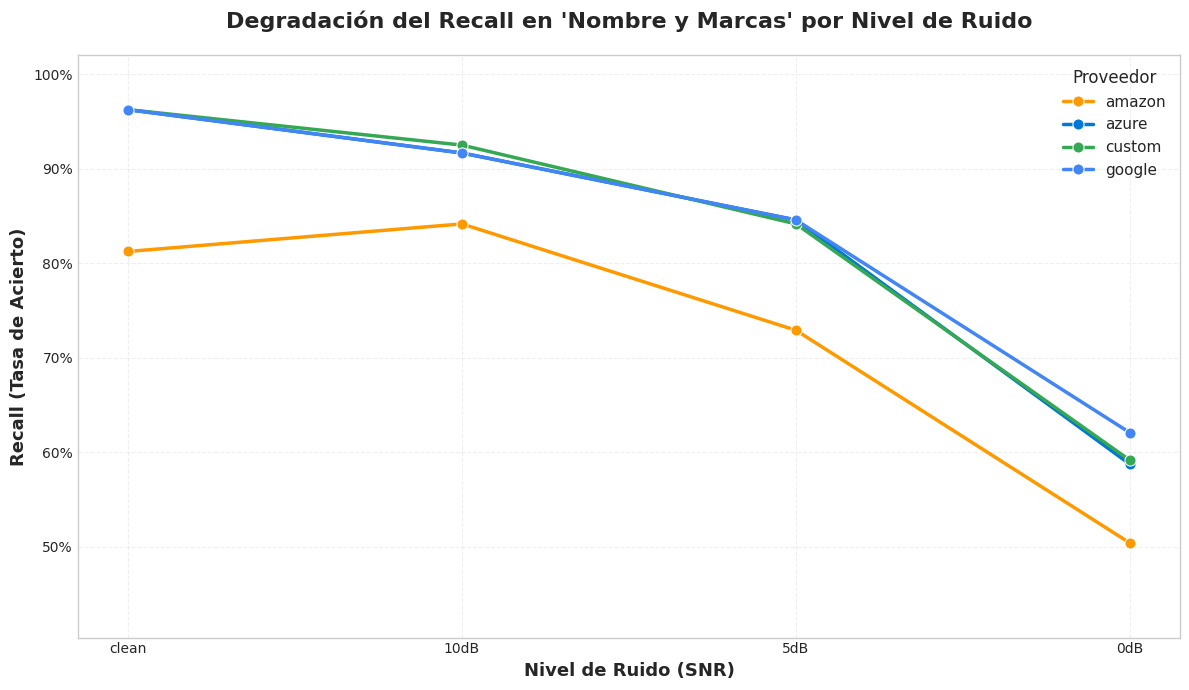

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Para representar la evolución del desempeño a través de niveles de ruido (variable ordinal),
# el gráfico más adecuado es un GRÁFICO DE LÍNEAS. Permite visualizar claramente la tendencia de degradación.

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Definir colores consistentes
colors = {'google': '#4285F4', 'azure': '#0078D4', 'amazon': '#FF9900', 'custom': '#34A853'}

# Crear gráfico de líneas
# Nota: brands_metrics ya tiene 'SNR' como categórico ordenado del paso anterior
sns.lineplot(data=brands_metrics, x='SNR', y='Recall', hue='Provider', 
             palette=colors, marker='o', linewidth=2.5, markersize=8)

# Personalización del gráfico
plt.title("Degradación del Recall en 'Nombre y Marcas' por Nivel de Ruido", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Nivel de Ruido (SNR)", fontsize=13, fontweight='bold')
plt.ylabel("Recall (Tasa de Acierto)", fontsize=13, fontweight='bold')

# Ajustar límites y formato dinámicamente para mejor apreciación
min_val = brands_metrics['Recall'].min()
lower_limit = max(0, min_val - 0.1) # Margen de 10% por debajo del valor mínimo
plt.ylim(lower_limit, 1.02)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.legend(title='Proveedor', fontsize=11, title_fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

plt.show()

In [37]:
# Calcular el total de slots evaluados en todo el dataset
total_slots_count = df_nlu['nlu_slot_status'].apply(len).sum()

print(f"Total de elementos en los diccionarios nlu_slot_status (Total de Slots Evaluados): {total_slots_count}")

# Agrupar por 'person' y sumar la cantidad de slots
slots_by_person = df_nlu.groupby('person')['nlu_slot_status'].apply(lambda x: x.apply(len).sum()).sort_values(ascending=False)

print("\nTotal de Slots Evaluados por Persona:")
display(slots_by_person.to_frame(name='Total Slots'))

Total de elementos en los diccionarios nlu_slot_status (Total de Slots Evaluados): 15200

Total de Slots Evaluados por Persona:


,Total Slots
person,
p1,1520
p10,1520
p2,1520
p3,1520
p4,1520
p5,1520
p6,1520
p7,1520
p8,1520


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

def graficar_matriz_confusion(df_resultados, titulo="Matriz de Confusión"):
    """
    Genera y visualiza la matriz de confusión de intenciones.
    
    Args:
        df_resultados: DataFrame con columnas 'intent_expected' y 'intent_predicted'.
        titulo: String para el título del gráfico (ej: "Google - Ruido 0dB").
    """
    
    # 1. Definir las etiquetas (Clases)
    # Obtenemos todas las intenciones posibles (incluyendo "no_match" si existe)
    y_real = df_resultados['intent_expected']
    y_pred = df_resultados['intent_predicted']
    
    etiquetas = sorted(list(set(y_real.unique()) | set(y_pred.unique())))
    
    # 2. Calcular la Matriz
    cm = confusion_matrix(y_real, y_pred, labels=etiquetas)
    
    # 3. Configurar el Gráfico (Heatmap)
    plt.figure(figsize=(12, 10)) # Tamaño grande para que se lean las etiquetas
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=etiquetas, yticklabels=etiquetas)
    
    # 4. Estética
    plt.title(titulo, fontsize=16, pad=20)
    plt.xlabel('Lo que PREDIJO el sistema', fontsize=12)
    plt.ylabel('Lo que ERA en realidad (Ground Truth)', fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotar etiquetas de abajo para leerlas bien
    plt.yticks(rotation=0)
    
    # Ajustar márgenes para que no se corte el texto
    plt.tight_layout()
    
    return plt

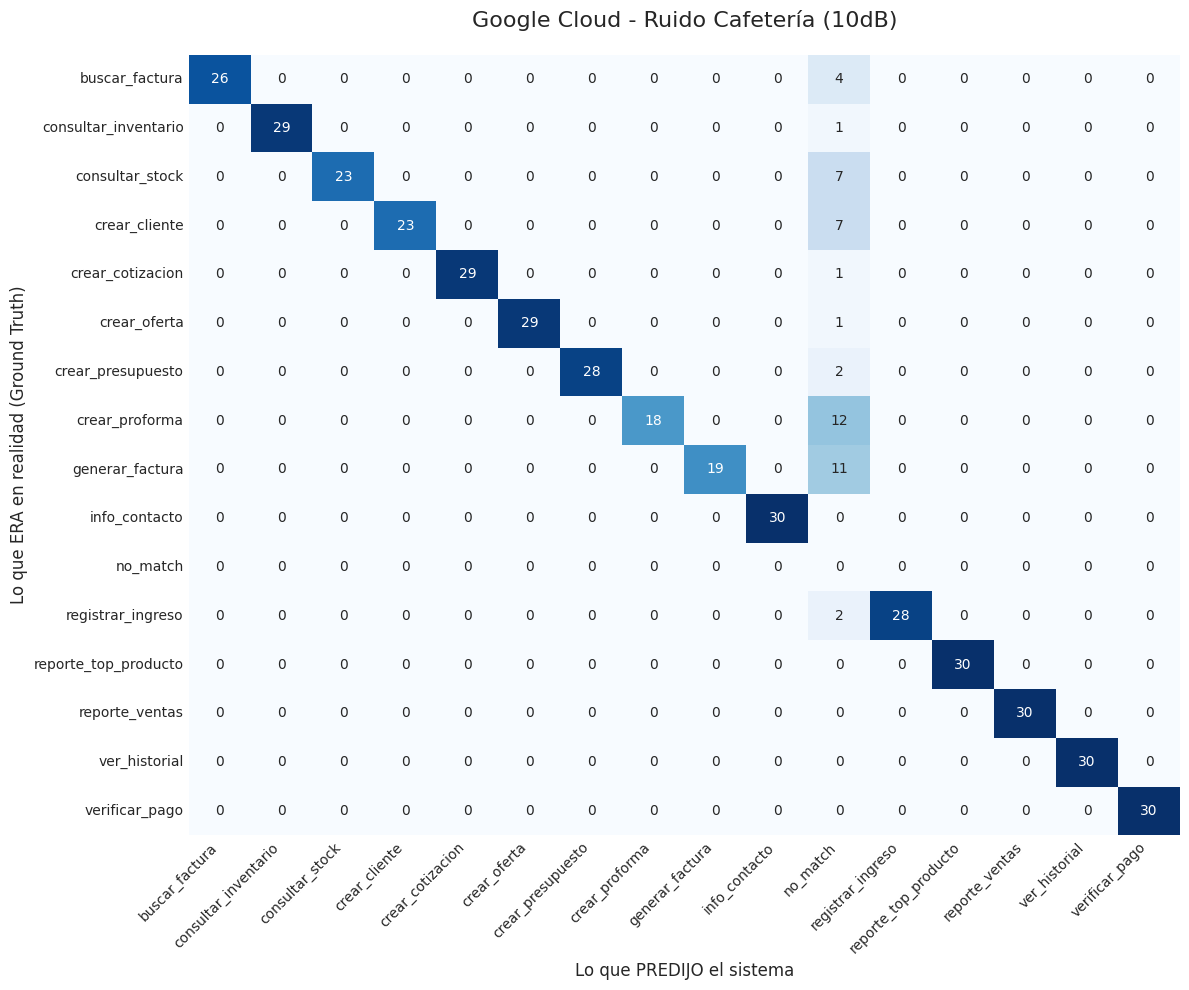

In [19]:
df_google = df_nlu[(df_nlu['snr_normalized'] == '0dB') & (df_nlu['provider'] == 'google')]
graficar_matriz_confusion(df_google, "Google Cloud - Ruido Cafetería (10dB)")
plt.show()

In [20]:
df_nlu.to_csv('nlu_dataset.csv', index=False)

## Ranking Final

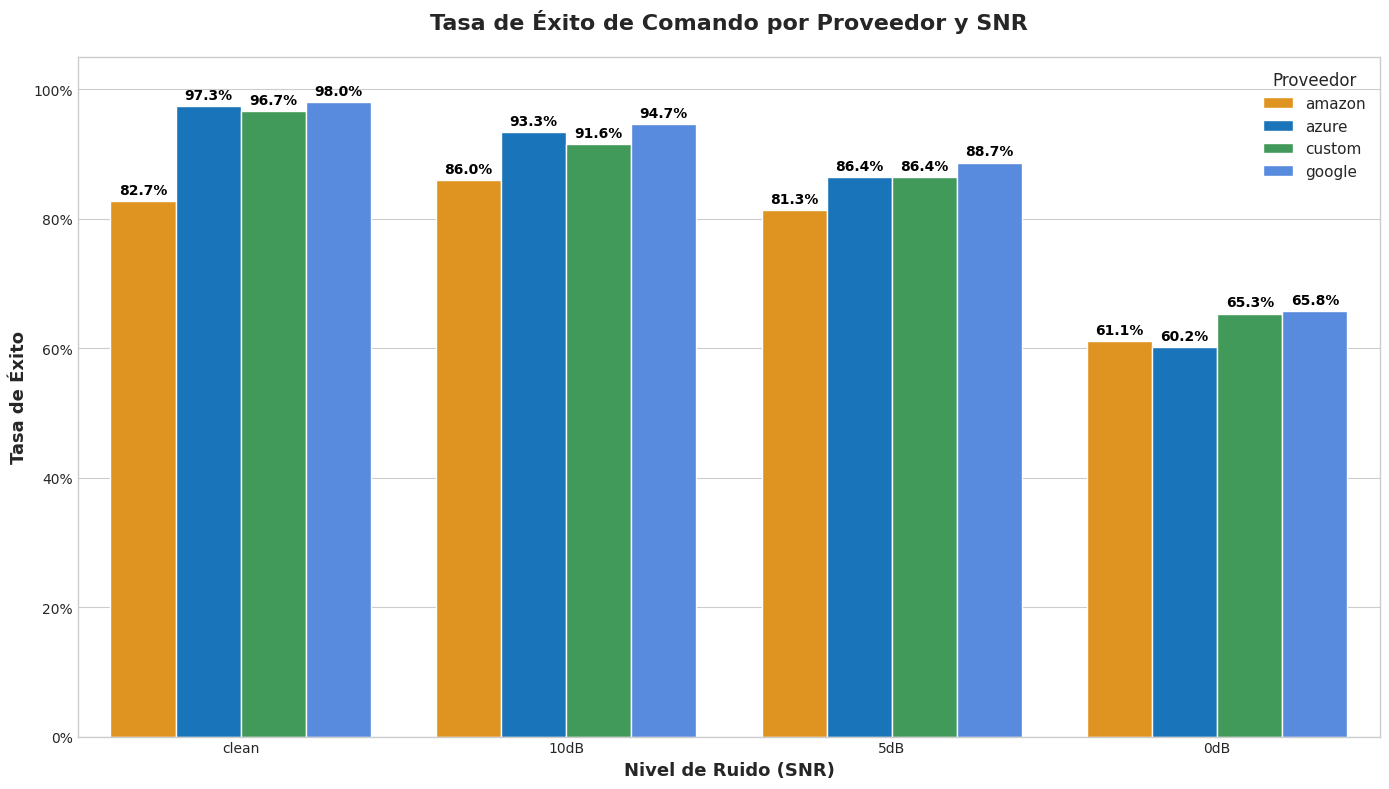

Tasa de Éxito de Comando (NLU Success):


snr_normalized,clean,10dB,5dB,0dB
provider,,,,
amazon,82.67%,86.00%,81.33%,61.11%
azure,97.33%,93.33%,86.44%,60.22%
custom,96.67%,91.56%,86.44%,65.33%
google,98.00%,94.67%,88.67%,65.78%


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import PercentFormatter

# 1. Preparar datos
# Agrupar por proveedor y SNR para calcular la tasa de éxito de comando (nlu_success)
command_success = df_nlu.groupby(['provider', 'snr_normalized'])['nlu_success'].mean().reset_index()

# Definir el orden de SNR para el gráfico
snr_order = ['clean', '10dB', '5dB', '0dB']
command_success['snr_cat'] = pd.Categorical(command_success['snr_normalized'], categories=snr_order, ordered=True)
command_success = command_success.sort_values('snr_cat')

# 2. Configurar el gráfico
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Definir colores
colors = {'google': '#4285F4', 'azure': '#0078D4', 'amazon': '#FF9900', 'custom': '#34A853'}

# Crear gráfico de barras
ax = sns.barplot(data=command_success, x='snr_normalized', y='nlu_success', hue='provider', 
                 palette=colors, order=snr_order)

# 3. Personalización
plt.title('Tasa de Éxito de Comando por Proveedor y SNR', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Nivel de Ruido (SNR)', fontsize=13, fontweight='bold')
plt.ylabel('Tasa de Éxito', fontsize=13, fontweight='bold')

# Formatear eje Y como porcentaje
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.ylim(0, 1.05)

# Añadir etiquetas de valor
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.1%}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 8), 
                    textcoords='offset points',
                    fontsize=10, fontweight='bold', color='black')

plt.legend(title='Proveedor', fontsize=11, title_fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

# Mostrar tabla de datos
print("Tasa de Éxito de Comando (NLU Success):")
display(command_success.pivot(index='provider', columns='snr_normalized', values='nlu_success')[snr_order].style.format("{:.2%}"))

In [71]:
# Filtrar datos para 0dB
df_0db = df_nlu[df_nlu['snr_normalized'] == '0dB'].copy()

# Calcular métricas promedio por proveedor
ranking_0db = df_0db.groupby('provider').agg(
    intent_acc=('intent_success', 'mean'),
    slots_acc=('slots_success', 'mean'),
    csr=('nlu_success', 'mean')
).reset_index()

# Ordenar por CSR descendente
ranking_0db = ranking_0db.sort_values('csr', ascending=False)

# Agregar columna de Ranking
ranking_0db['Ranking'] = range(1, len(ranking_0db) + 1)

# Renombrar columnas
ranking_0db = ranking_0db.rename(columns={
    'provider': 'Proveedor',
    'intent_acc': '% Precisión de Intención',
    'slots_acc': '% Precisión de Entidades',
    'csr': 'Tasa de Éxito (CSR)'
})

# Reordenar columnas
ranking_0db = ranking_0db[['Ranking', 'Proveedor', '% Precisión de Intención', '% Precisión de Entidades', 'Tasa de Éxito (CSR)']]

# Mostrar tabla
print("Ranking de Desempeño en Ruido Extremo (0dB):")
display(ranking_0db.style.format({
    '% Precisión de Intención': '{:.2%}',
    '% Precisión de Entidades': '{:.2%}',
    'Tasa de Éxito (CSR)': '{:.2%}'
}).hide(axis='index').set_properties(**{
    'text-align': 'center',
    'padding': '10px'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#2c3e50'), ('color', 'white')]}
]).background_gradient(cmap='RdYlGn', subset=['% Precisión de Intención', '% Precisión de Entidades', 'Tasa de Éxito (CSR)']))

Ranking de Desempeño en Ruido Extremo (0dB):


Ranking,Proveedor,% Precisión de Intención,% Precisión de Entidades,Tasa de Éxito (CSR)
1,google,89.33%,71.33%,65.78%
2,custom,90.44%,70.22%,65.33%
3,amazon,93.11%,64.67%,61.11%
4,azure,87.56%,68.00%,60.22%
